# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

In [575]:
# Import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import pandas as pd
pd.set_option("display.max_columns", 120)
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re
import seaborn as sns
from functools import reduce

## Load Data

In [ ]:
# Create a Spark session
spark = SparkSession.builder.appName('sparkify').getOrCreate()

In [590]:
# Load the user log data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

## Explore Data

### Overview

In [494]:
# Take a look on the first three rows
user_log.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

### Data types

In [495]:
# Print data types
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [496]:
# Investigate non numeric user IDs
user_log.filter('userid not rlike "[0-9]+"').select('userid').dropDuplicates().collect()

[Row(userid='')]

In [497]:
# Investigate authentication of non numeric user IDs
user_log.filter(user_log.userId == "").select('auth').dropDuplicates().collect()

[Row(auth='Logged Out'), Row(auth='Guest')]

All columns have appropriate data types, except the `userId` column. I will later drop events of unregistered users (those with `userId = ''`) and then convert the variable from string to integer.

### Missing values

In [498]:
# Count missing values
user_log.select([F.count(F.when(F.isnull(col) | F.isnan(col), 1)).alias(col) for col in user_log.columns]).collect()

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=0)]

In [499]:
# Count missing values only for registered users
cond1 = (user_log.userId != '')
user_log.filter(cond1).select([F.count(F.when(F.isnull(col) | F.isnan(col), 1)).alias(col) for col in user_log.columns]).collect()

[Row(artist=50046, auth=0, firstName=0, gender=0, itemInSession=0, lastName=0, length=50046, level=0, location=0, method=0, page=0, registration=0, sessionId=0, song=50046, status=0, ts=0, userAgent=0, userId=0)]

In [500]:
# Count missing values only for registered users and song pages
cond2 = (user_log.page == "NextSong")
user_log.filter(cond1 & cond2).select([F.count(F.when(F.isnull(col) | F.isnan(col), 1)).alias(col) for col in user_log.columns]).collect()

[Row(artist=0, auth=0, firstName=0, gender=0, itemInSession=0, lastName=0, length=0, level=0, location=0, method=0, page=0, registration=0, sessionId=0, song=0, status=0, ts=0, userAgent=0, userId=0)]

There seems to be no major issue with missing values. Missing values occur in user specific variables (`firstName`, `gender`, `lastName`, `location`, `registration`, `userAgent`) only for events of unregistered users (for which holds `userId == ''`), as well as in song specific variables (`artist`, `length`, `song`) for not song-related events (for which holds `page != "NextSong"`). 

### Timestamps

In [512]:
# Minimal and maximal registration date
user_log.select('registration').agg(F.from_unixtime(F.min('registration') / 1000, 'yyyy-MM-dd').alias('min')).collect(), \
user_log.select('registration').agg(F.from_unixtime(F.max('registration') / 1000, 'yyyy-MM-dd').alias('min')).collect()

([Row(min='2018-03-18')], [Row(min='2018-11-26')])

In [513]:
# Minimal and maximal event date
user_log.select('ts').agg(F.from_unixtime(F.min('ts') / 1000, 'yyyy-MM-dd').alias('min')).collect(), \
user_log.select('ts').agg(F.from_unixtime(F.max('ts') / 1000, 'yyyy-MM-dd').alias('min')).collect()

([Row(min='2018-10-01')], [Row(min='2018-12-03')])

This is an important insight for modeling on the small user log subset. There are users of which we don't have the full history (those who have registered before 2018-10-01). This is something we should consider in the feature generation phase, since otherwise, if we do not act wisely, our model could suffer from bias.

### Categorical variables

In [516]:
# Get number of unique values and top 10 values of categorical data
df = user_log.toPandas()
for col in df.columns[(df.dtypes == 'object') & (df.columns!='userId')]:
    top10 = df[col].value_counts().index[:10].tolist()
    print(col + " ({})".format(df[col].nunique()))
    print(top10)

artist (17655)
['Kings Of Leon', 'Coldplay', 'Florence + The Machine', 'Dwight Yoakam', 'BjÃ\x83Â¶rk', 'The Black Keys', 'Muse', 'Justin Bieber', 'Jack Johnson', 'Eminem']
auth (4)
['Logged In', 'Logged Out', 'Guest', 'Cancelled']
firstName (189)
['Payton', 'Riley', 'Lucero', 'Emilia', 'Emma', 'Joseph', 'Colin', 'Nicole', 'Joshua', 'Brayden']
gender (2)
['F', 'M']
lastName (173)
['Campbell', 'Reed', 'Williams', 'Taylor', 'Johnson', 'Larson', 'House', 'Thompson', 'Jones', 'Beck']
level (2)
['paid', 'free']
location (114)
['Los Angeles-Long Beach-Anaheim, CA', 'New York-Newark-Jersey City, NY-NJ-PA', 'Boston-Cambridge-Newton, MA-NH', 'Houston-The Woodlands-Sugar Land, TX', 'Charlotte-Concord-Gastonia, NC-SC', 'Dallas-Fort Worth-Arlington, TX', 'Louisville/Jefferson County, KY-IN', 'Philadelphia-Camden-Wilmington, PA-NJ-DE-MD', 'Chicago-Naperville-Elgin, IL-IN-WI', 'St. Louis, MO-IL']
method (2)
['PUT', 'GET']
page (22)
['NextSong', 'Home', 'Thumbs Up', 'Add to Playlist', 'Add Friend', 'R

### Numerical variables

In [521]:
# Get description of numerical variables
df.describe()

,itemInSession,length,registration,sessionId,status,ts
count,286500.000000,228108.000000,2.781540e+05,286500.000000,286500.000000,2.865000e+05
mean,114.414213,249.117182,1.535359e+12,1041.526555,210.054597,1.540957e+12
std,129.767262,99.235179,3.291322e+09,726.776263,31.505078,1.507544e+09
min,0.000000,0.783220,1.521381e+12,1.000000,200.000000,1.538352e+12
25%,27.000000,199.888530,1.533522e+12,336.000000,200.000000,1.539697e+12
50%,70.000000,234.500770,1.536664e+12,1013.000000,200.000000,1.540932e+12
75%,156.250000,277.158730,1.537672e+12,1675.000000,200.000000,1.542266e+12
max,1321.000000,3024.665670,1.543247e+12,2474.000000,404.000000,1.543799e+12


### Activity over time

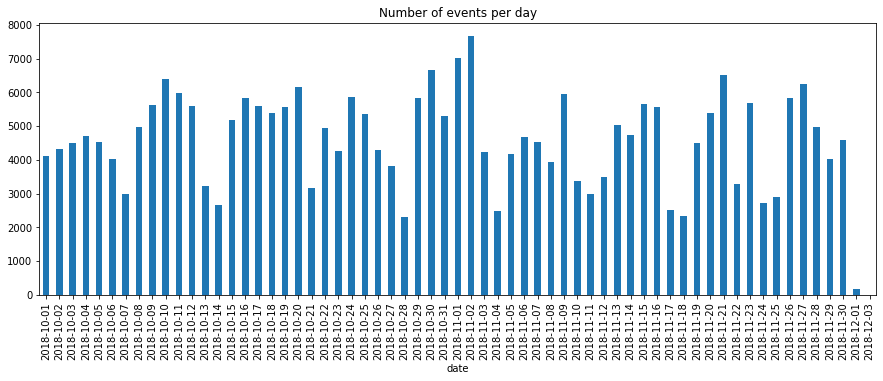

In [557]:
# Plot events per day
get_date =  F.udf(lambda x: datetime.fromtimestamp(x/1000), DateType())
events_per_date = user_log.withColumn('date', get_date('ts')).groupBy('date').count().alias('events')
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_title("Number of events per day")
events_per_date.toPandas().set_index('date').sort_index().plot(kind='bar', ax=ax)
ax.get_legend().remove()
plt.show()

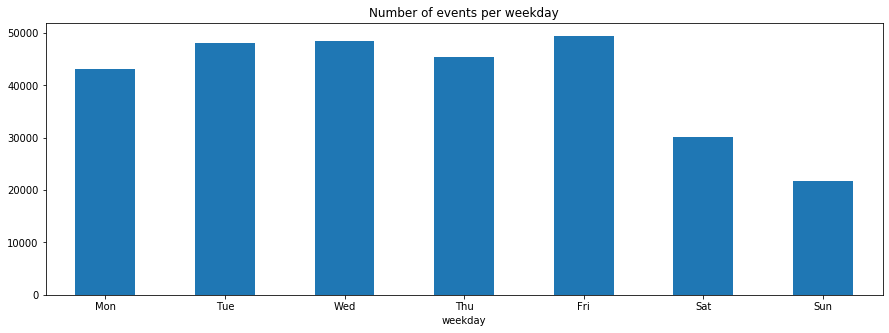

In [570]:
# Plot events per weekday
get_weekday = F.udf(lambda x: datetime.fromtimestamp(x/1000).weekday(), IntegerType())
events_per_weekday = user_log.withColumn('weekday', get_weekday('ts')).groupBy('weekday').count()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_title("Number of events per weekday")
events_per_weekday.toPandas().set_index('weekday').sort_index().plot(kind='bar', ax=ax)
ax.set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], rotation=0)
ax.xaxis.set_tick_params(rotation=0)
ax.get_legend().remove()
plt.show()

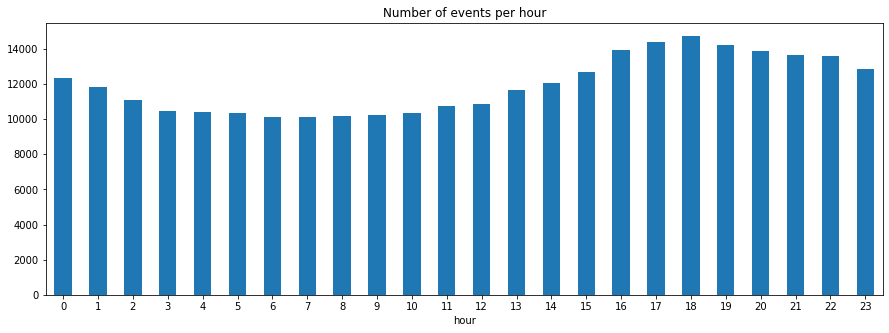

In [568]:
# Plot events per hour
get_hour = F.udf(lambda x: datetime.fromtimestamp(x/1000).hour, IntegerType())
events_per_hour = user_log.withColumn('hour', get_hour('ts')).groupBy('hour').count()
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.set_title("Number of events per hour")
events_per_hour.toPandas().set_index('hour').sort_index().plot(kind='bar', ax=ax)
ax.xaxis.set_tick_params(rotation=0)
ax.get_legend().remove()
plt.show()

### Number of events per page

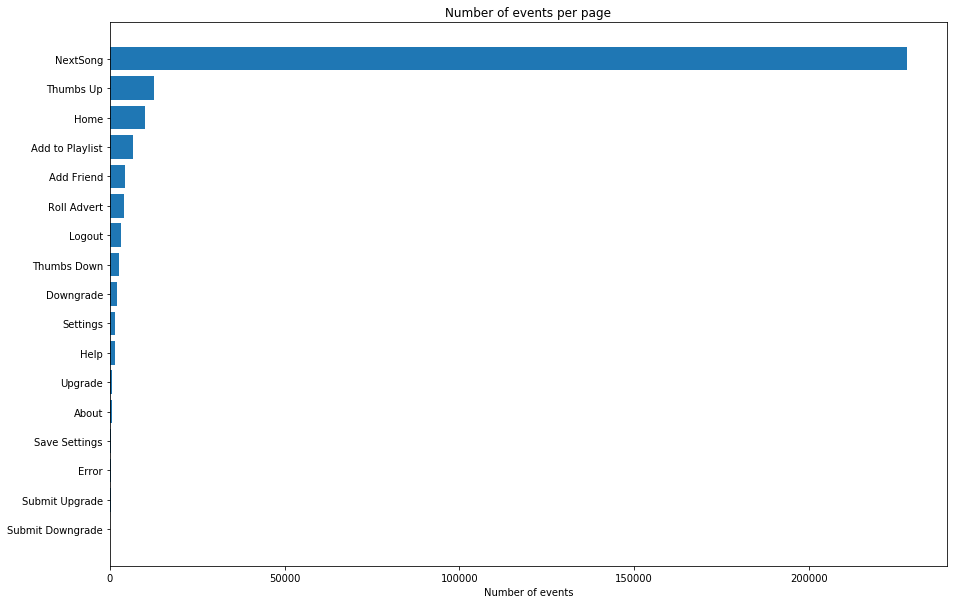

In [663]:
# Plot number of events per page
num_events_per_page = user_log.groupBy('page').count().toPandas().sort_values('count')
plt.figure(figsize=(15, 10))
plt.title("Number of events per page")
plt.barh(num_events_per_page['page'], num_events_per_page['count'])
plt.xlabel("Number of events")
plt.show()

## Clean Data

### Remove unregistered users

In [591]:
def clean_user_log(user_log):
    """ Prepares the user log data for the feature generation process 
    
    Input:
        user_log (DataFrame) - the original user log data
        
    Output:
        DataFrame - cleansed user log data
    
    """

    # Cast userid column to integer and remove unregistered users
    user_log = user_log.withColumn('userId', user_log['userId'].cast(IntegerType()))
    user_log = user_log.filter(user_log.userId.isNotNull())
    
    return user_log

In [592]:
user_log = clean_user_log(user_log)
user_log.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [489]:
# Is the dataset clean now?
user_log.filter( (F.col('userId').isNull()) | (F.col('userId') == '')).collect()

[]

### Save churn users 

In [593]:
def get_churn_users(user_log):
    """ Gets the user IDs of churn users in user log
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
    
    Output:
        list - churn user IDs
    
    """
    
    churn_users = user_log.filter(F.col('page') == "Cancellation Confirmation")\
                      .select('userId').dropDuplicates()\
                      .rdd.flatMap(lambda x: x).collect()
    
    return churn_users

In [525]:
churn_users = get_churn_users(user_log)
print("There are {} churn users in the sample".format(len(churn_users)))
print("Examples:", churn_users[:5])

There are 52 churn users in the sample
Examples: ['125', '51', '54', '100014', '101']


### Create flag for churn users and remove cancellation events

In [594]:
def create_churn_flag(user_log, churn_users):
    """ Adds churn flag to each event of the user log and removes 
    cancellation events
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - new user log data set
    
    """
    
    # Create churn user flag for user log data
    is_churn_user = F.udf(lambda x: int(x in churn_users), IntegerType())
    user_log = user_log.withColumn('churn', is_churn_user('userId'))
    
    # Remove cancellation events
    user_log = user_log.filter(~F.col('page').isin(["Cancellation Confirmation", "Cancel"]))
    
    return user_log

In [595]:
user_log = create_churn_flag(user_log, churn_users)
user_log.toPandas().head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9,0
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30,0


In [425]:
# Are the cancellation events removed?
user_log.filter(user_log.page.isin(["Cancellation Confirmation", "Cancel"])).collect()

[]

## Generate Features

### Gender

In [596]:
def get_gender(user_log):
    """ Gets the gender of each user 
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
    
    Output:
        DataFrame - gender per user
    
    """
    
    # Get and encode gender per user
    gender = user_log.withColumn('gender', F.when(F.col('gender') == 'M', 1).otherwise(0))\
                     .select('userId', 'gender').dropDuplicates()
    
    return gender

In [597]:
gender = get_gender(user_log)

In [578]:
# Make pandas dataframe for exploration
gender_pandas = gender.toPandas()
gender_pandas['churn'] = gender_pandas['userId'].isin(churn_users).astype(int)
gender_pandas.head()

,userId,gender,churn
0,73,0,1
1,37,1,0
2,19,0,0
3,134,1,0
4,139,1,0


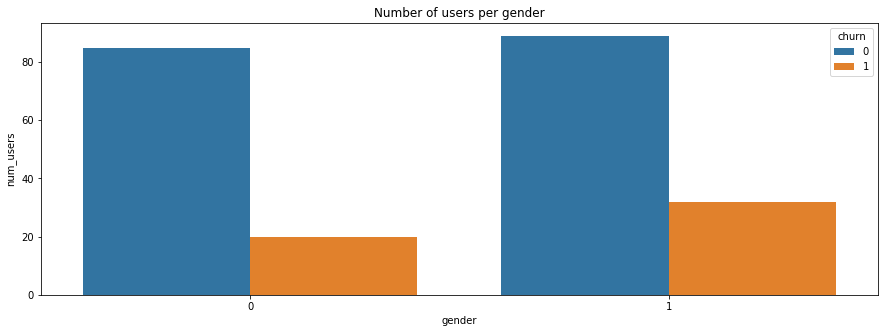

In [616]:
# Plot number of users per gender
gender_pandas_plot = gender_pandas.groupby(['gender', 'churn'], as_index=False).count()
gender_pandas_plot.columns = ['gender', 'churn', 'num_users']
plt.figure(figsize=(15, 5))
plt.title("Number of users per gender")
sns.barplot(x = 'gender', y = 'num_users', hue = 'churn', data = gender_pandas_plot)
plt.show()

### Metropolian Area

In [598]:
def get_metropolian_area_dummies(user_log):
    """ Creates dataframe with dummies for the metropolian area users are 
    living in. The information can be extracted from the `location` column in
    the user log data.
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - one hot encoded metropolian area of each user
    
    """
    
    # Create metropolian area feature
    get_state = F.udf(lambda x: x.split(', ')[1], StringType())
    user_log = user_log.withColumn('area', get_state('location'))
    
    # Get dummies and fill missing values with 0
    area_dummies = user_log.select(['userId', 'area']).dropDuplicates()\
                            .groupBy('userId').pivot('area').count()
    area_dummies = area_dummies.fillna(0)
    
    return area_dummies

In [599]:
area = get_metropolian_area_dummies(user_log)

In [600]:
# Make pandas dataframe for exploration
area_pandas = area.toPandas()
area_pandas['churn'] = area_pandas['userId'].isin(churn_users).astype(int)
area_pandas.head()

,userId,AK,AL,AR,AZ,CA,CO,CT,DC-VA-MD-WV,FL,GA,GA-AL,IA,IL,IL-IN-WI,IL-MO,IN,KY,KY-IN,LA,MA-NH,MD,MD-WV,MI,MN-WI,MO-IL,MO-KS,MS,MT,NC,NC-SC,NE-IA,NH,NJ,NV,NY,NY-NJ-PA,OH,OH-KY-IN,OK,OR,OR-WA,PA,PA-NJ,PA-NJ-DE-MD,RI-MA,SC,SC-NC,TN,TN-MS-AR,TN-VA,TX,UT,UT-ID,VA,VA-NC,WA,WI,WV,churn
0,148,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,85,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,200001,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


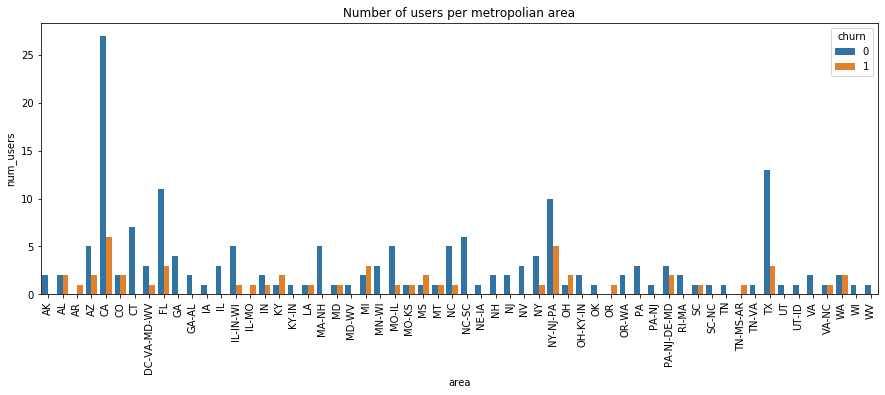

In [617]:
# Plot number of users per metropolian area
area_pandas_plot = area_pandas.groupby('churn').sum().drop('userId', axis=1).unstack().reset_index()
area_pandas_plot.columns = ['area', 'churn', 'num_users']
plt.figure(figsize=(15, 5))
plt.title("Number of users per metropolian area")
sns.barplot(x = 'area', y = 'num_users', hue = 'churn', data = area_pandas_plot)
plt.xticks(rotation=90)
plt.show()

### Device

In [ ]:
def get_device_dummies(user_log):
    """ Creates dataframe with dummies for the devices each user
    uses. The information can be extracted from the `userAgent`
    column in the user log data.
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - one hot encoded devices of each user
    
    """
    
    # Create mapper for the derivation of device types
    device_mapper = {'Windows NT 6.1': 'Windows', 'Macintosh': 'Mac', 'Windows NT 6.0': 'Windows', 
                 'Windows NT 6.2': 'Windows', 'iPhone': 'iPhone', 'Windows NT 6.3': 'Windows', 
                 'iPad': 'iPad', 'compatible': 'Windows', 'X11': 'Linux', 
                 'Windows NT 5.1': 'Windows'}
    
    # Create device column 
    # Note: If device type is unknown, assign `unknown device` type
    get_device = F.udf(lambda x: device_mapper.get(re.findall(r'\((.+?)\)', x)[0].split(';')[0], 'Unknown Device'), 
                       StringType() )
    user_log = user_log.withColumn('device', get_device('userAgent'))
    
    # Get dummies and fill missing values with 0
    device_dummies = user_log.select(['userId', 'device']).dropDuplicates()\
                            .groupBy('userId').pivot('device').count()
    device_dummies = device_dummies.fillna(0)
    
    return device_dummies

In [618]:
device = get_device_dummies(user_log)

In [619]:
# Make pandas dataframe for exploration
device_pandas = device.toPandas()
device_pandas['churn'] = device_pandas['userId'].isin(churn_users).astype(int)
device_pandas.head()

,userId,Linux,Mac,Windows,iPad,iPhone,churn
0,148,0,0,1,0,0,0
1,137,0,1,0,0,0,0
2,85,0,1,0,0,0,0
3,65,1,0,0,0,0,0
4,200001,0,0,1,0,0,1


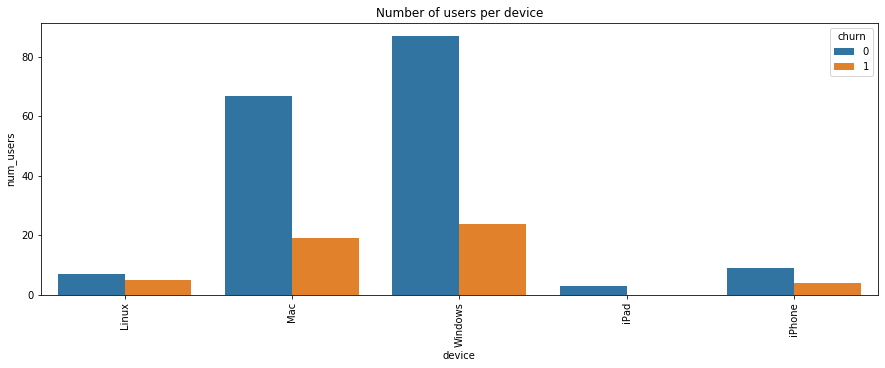

In [620]:
# Plot number of users per device
device_pandas_plot = device_pandas.groupby('churn').sum().drop('userId', axis=1).unstack().reset_index()
device_pandas_plot.columns = ['device', 'churn', 'num_users']
plt.figure(figsize=(15, 5))
plt.title("Number of users per device")
sns.barplot(x = 'device', y = 'num_users', hue = 'churn', data = device_pandas_plot)
plt.xticks(rotation=90)
plt.show()

In [634]:
# Are there multidevice users?
device_pandas.loc[device_pandas.iloc[:,1:-1].sum(axis=1)>1, 'userId']

Series([], Name: userId, dtype: int32)

### Status

In [639]:
def get_current_status(user_log):
    """ Gets the current status of each user
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - current status per user (0=unpaid, 1=paid)
    
    """
    
    # Get payment mode of last event of users
    window_var = Window().partitionBy('userId').orderBy(F.desc('ts'))
    current_status = user_log.withColumn('rn', F.row_number().over(window_var))\
                           .filter(F.col('rn')==1).select(['userId', 'level'])
    
    # Make binary feature (0=unpaid, 1=paid)
    is_user_paying = F.udf(lambda x: 1 if x=="paid" else 0, IntegerType())
    current_status = current_status.withColumn('level', is_user_paying('level'))
    current_status = current_status.withColumnRenamed('level', 'Pay Status')
    
    return current_status

In [640]:
status = get_current_status(user_log)

In [641]:
# Make pandas dataframe for exploration
status_pandas = status.toPandas()
status_pandas['churn'] = status_pandas['userId'].isin(churn_users).astype(int)
status_pandas.head()

,userId,Pay Status,churn
0,148,0,0
1,85,1,0
2,137,1,0
3,65,1,0
4,200001,0,1


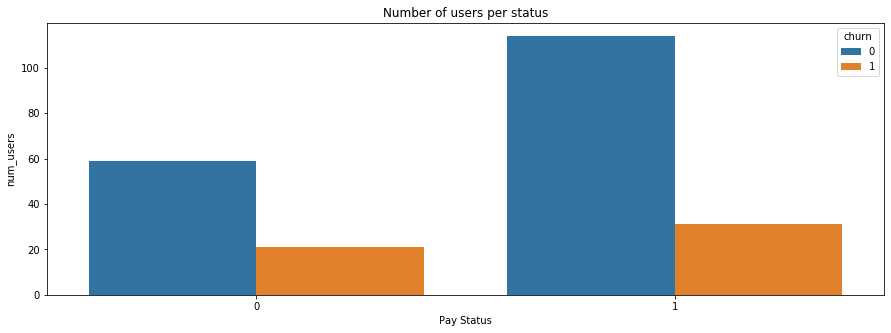

In [644]:
# Plot number of users per status
status_pandas_plot = status_pandas.groupby(['Pay Status', 'churn'], as_index=False).count()
status_pandas_plot.columns = ['Pay Status', 'churn', 'num_users']
plt.figure(figsize=(15, 5))
plt.title("Number of users per status")
sns.barplot(x = 'Pay Status', y = 'num_users', hue = 'churn', data = status_pandas_plot)
plt.show()

### Number of sessions

In [453]:
def get_number_of_sessions(user_log):
    """ Calculates the average number of sessions per week for each user
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - average number of sessions per week per user
    
    """
    
    # Calculate length of observation period for each user
    start_date_min = user_log.agg({'ts': 'min'}).collect()[0][0]
    end_date_max = user_log.agg({'ts': 'max'}).collect()[0][0]
    window_var = Window().partitionBy('userId')
    user_log = user_log.withColumn('start_ts',\
                               F.when(F.col('registration') >= start_date_min, F.max(F.col('registration')).over(window_var))\
                               .otherwise(start_date_min))\
                       .withColumn('end_ts',\
                               F.when(F.col('churn') == 1, F.max(F.col('ts')).over(window_var))\
                               .otherwise(end_date_max))\
                       .withColumn('duration_weeks', (F.col('end_ts') - F.col('start_ts')) / (1000 * 60 * 60 * 24 * 7))
        
    # Calculate number of sessions per week and user
    num_sessions = user_log.groupBy('userId', 'duration_weeks')\
                           .agg((F.countDistinct('sessionId') / F.col('duration_weeks')).alias('Sessions Per Week'))\
                           .select('userId', 'Sessions Per Week')
    
    return num_sessions

In [645]:
sessions = get_number_of_sessions(user_log)

In [646]:
# Make pandas dataframe for exploration
sessions_pandas = sessions.toPandas()
sessions_pandas['churn'] = sessions_pandas['userId'].isin(churn_users).astype(int)
sessions_pandas.head()

,userId,Sessions Per Week,churn
0,148,1.332315,0
1,85,4.552077,0
2,137,0.333079,0
3,65,2.553604,0
4,200001,0.666158,1


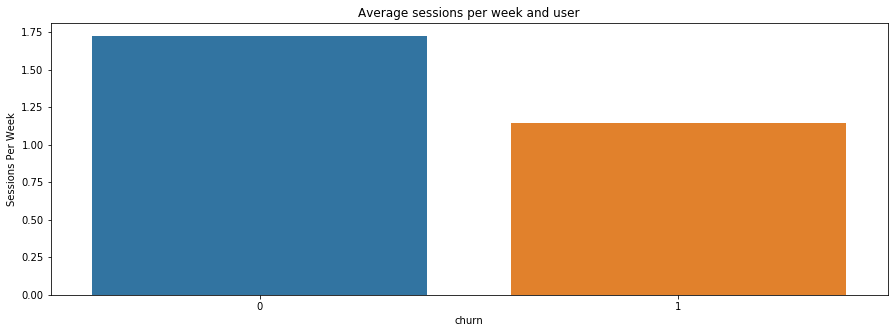

In [650]:
# Plot sessions per week and user
sessions_pandas_plot = sessions_pandas.groupby('churn', as_index=False)['Sessions Per Week'].mean()
plt.figure(figsize=(15, 5))
plt.title("Average sessions per week and user")
sns.barplot(x = 'churn', y = 'Sessions Per Week', data = sessions_pandas_plot)
plt.show()

### Average session length

In [450]:
def calculate_session_length(user_log):
    """ Calculates the average length of all sessions of a user 
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - average session length per user
    
    """

    # Calculate length per session
    session_length = user_log.groupBy(['userId', 'sessionId'])\
                             .agg((F.max('ts')-F.min('ts')).alias('session_length'))
    
    # Calculate average length of all sessions per user
    avg_session_length = session_length.groupBy('userId')\
                                       .agg((F.mean('session_length')/60000).alias('Length Per Session'))
    
    return avg_session_length

In [654]:
length = calculate_session_length(user_log)

In [652]:
# Make pandas dataframe for exploration
length_pandas = length.toPandas()
length_pandas['churn'] = length_pandas['userId'].isin(churn_users).astype(int)
length_pandas.head()

,userId,Length Per Session,churn
0,148,132.355556,0
1,85,370.846341,0
2,137,211.261111,0
3,200001,83.508333,1
4,65,384.174638,0


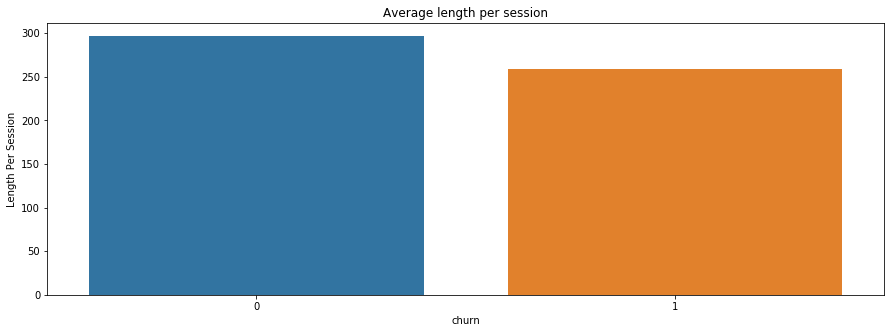

In [653]:
# Plot length per session 
length_pandas_plot = length_pandas.groupby('churn', as_index=False)['Length Per Session'].mean()
plt.figure(figsize=(15, 5))
plt.title("Average length per session")
sns.barplot(x = 'churn', y = 'Length Per Session', data = length_pandas_plot)
plt.show()

### Days since registration

In [456]:
def calculate_days_since_registration(user_log):
    """ Calculates the number of days between the registration of a user 
    and the prediction date
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - days since registration
    
    """
    
    # Get prediction timestamp for each user
    end_date_max = user_log.agg({'ts': 'max'}).collect()[0][0]
    window_var = Window().partitionBy('userId')
    user_log = user_log.withColumn('end_ts',\
                               F.when(F.col('churn') == 1, F.max(F.col('ts')).over(window_var))\
                               .otherwise(end_date_max))
    
    # Calculate difference between prediction and registration timestamp
    registration = user_log.select('userId', 'registration', 'end_ts').dropDuplicates()\
                           .withColumn('Days Since Registration', (F.col('end_ts') - F.col('registration')) \
                                      / (1000 * 60 * 60 * 24))\
                           .select('userId', 'Days Since Registration')
    
    return registration

In [655]:
registration = calculate_days_since_registration(user_log)

In [656]:
# Make pandas dataframe for exploration
registration_pandas = registration.toPandas()
registration_pandas['churn'] = registration_pandas['userId'].isin(churn_users).astype(int)
registration_pandas.head()

,userId,Days Since Registration,churn
0,148,72.550926,0
1,85,111.870116,0
2,137,131.351968,0
3,65,74.678993,0
4,200001,64.170093,1


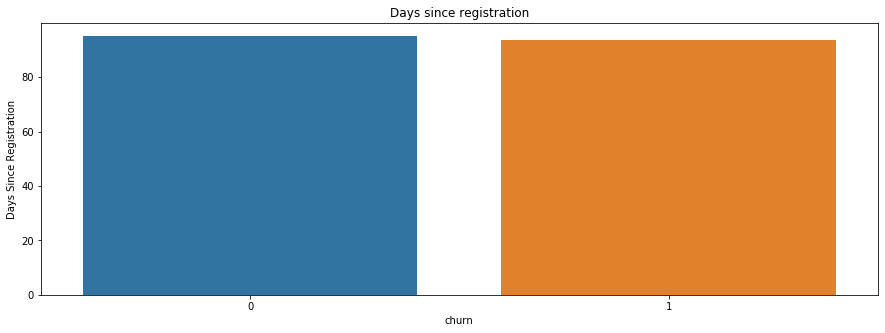

In [658]:
# Plot days since registration
registration_pandas_plot = registration_pandas.groupby('churn', as_index=False)['Days Since Registration'].mean()
plt.figure(figsize=(15, 5))
plt.title("Days since registration")
sns.barplot(x = 'churn', y = 'Days Since Registration', data = registration_pandas_plot)
plt.show()

### Page share

In [671]:
def calculate_page_share(user_log):
    """ Calculates the share of each page on all events of a user
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - page shares per user
    
    """

    
    vals = ['Home', 'NextSong', 'Roll Advert', 'Thumbs Up', 'Add Friend', 'Logout', 'Add to Playlist', 
            'Upgrade', 'Help', 'Settings', 'Thumbs Down', 'About', 'Submit Upgrade', 'Downgrade', 
            'Submit Downgrade', 'Error', 'Save Settings']
    
    pages = user_log.groupBy('userId', 'sessionId', 'itemInSession').pivot('page').count()
    pages = pages.na.fill(0)
    pages = pages.groupBy('userId').mean()
    pages = pages.select('userId', *(F.col("avg("+x+")").alias(x) for x in vals))
    
    return pages

In [672]:
pages = calculate_page_share(user_log)

In [673]:
# Make pandas dataframe for exploration
pages_pandas = pages.toPandas()
pages_pandas['churn'] = pages_pandas['userId'].isin(churn_users).astype(int)
pages_pandas.head()

,userId,Home,NextSong,Roll Advert,Thumbs Up,Add Friend,Logout,Add to Playlist,Upgrade,Help,Settings,Thumbs Down,About,Submit Upgrade,Downgrade,Submit Downgrade,Error,Save Settings,churn
0,148,0.050193,0.768340,0.061776,0.054054,0.013514,0.017375,0.009653,0.005792,0.005792,0.005792,0.005792,0.001931,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,85,0.035927,0.827460,0.007551,0.043936,0.013272,0.012357,0.024714,0.001602,0.005492,0.005721,0.008696,0.001373,0.000686,0.009611,0.000458,0.000458,0.000686,0
2,137,0.057416,0.736842,0.047847,0.038278,0.038278,0.023923,0.019139,0.019139,0.004785,0.004785,0.004785,0.000000,0.004785,0.000000,0.000000,0.000000,0.000000,0
3,65,0.031447,0.830582,0.003145,0.043632,0.020833,0.008255,0.026730,0.001179,0.005110,0.009041,0.006682,0.002358,0.000393,0.007862,0.000000,0.000000,0.002752,0
4,200001,0.064103,0.737179,0.019231,0.064103,0.000000,0.025641,0.019231,0.006410,0.006410,0.038462,0.006410,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,1


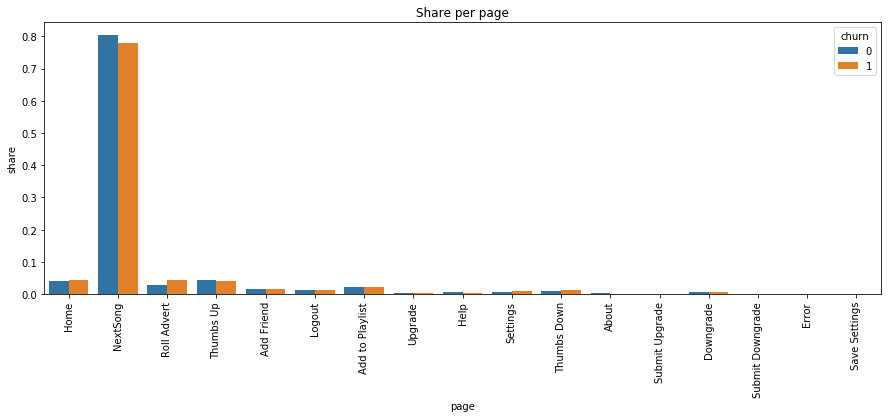

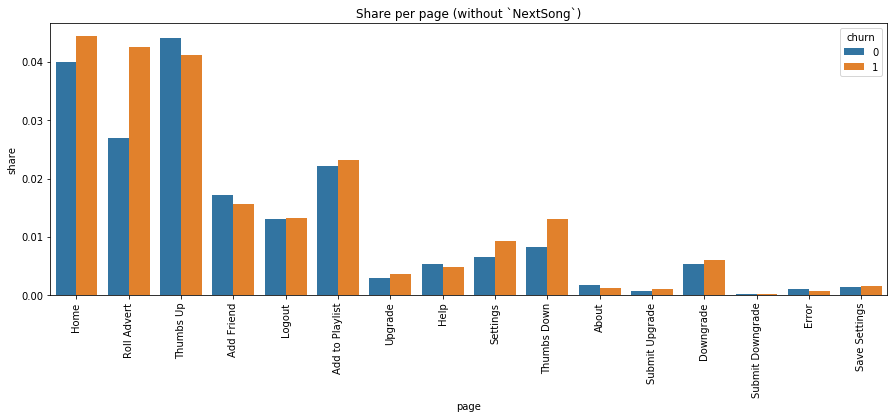

In [674]:
# Plot share per page
pages_pandas_plot = pages_pandas.groupby('churn').mean().drop('userId', axis=1).unstack().reset_index()
pages_pandas_plot.columns = ['page', 'churn', 'share']

# All pages
plt.figure(figsize=(15, 5))
plt.title("Share per page")
sns.barplot(x = 'page', y = 'share', hue = 'churn', data = pages_pandas_plot)
plt.xticks(rotation=90)
plt.show()

# Without Nextsong
plt.figure(figsize=(15, 5))
plt.title("Share per page (without `NextSong`)")
sns.barplot(x = 'page', y = 'share', hue = 'churn', data = pages_pandas_plot[pages_pandas_plot.page!='NextSong'])
plt.xticks(rotation=90)
plt.show()

### Average plays per song

In [466]:
def calculate_average_plays_per_song(user_log):
    """ Calculates how often users on average listen to the same song
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - average plays per sond per user
    
    """
    
    plays = user_log.filter(user_log.page == 'NextSong')\
                         .groupBy('userId').agg((F.count('song') / F.countDistinct('song'))\
                                                .alias('Average Plays Per Song'))
    
    return plays

In [678]:
plays = calculate_average_song_plays(user_log)

In [676]:
# Make pandas dataframe for exploration
plays_pandas = plays.toPandas()
plays_pandas['churn'] = plays_pandas['userId'].isin(churn_users).astype(int)
plays_pandas.head()

,userId,Average Plays Per Song,churn
0,148,1.041885,0
1,85,1.178234,0
2,137,1.006536,0
3,65,1.150245,0
4,200001,1.008772,1


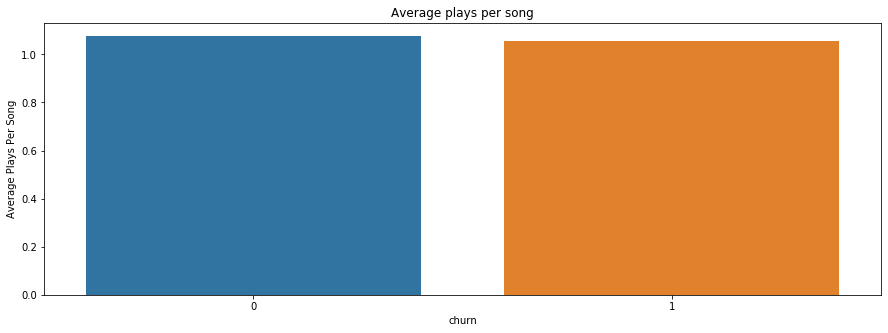

In [677]:
# Plot length per session 
plays_pandas_plot = plays_pandas.groupby('churn', as_index=False)['Average Plays Per Song'].mean()
plt.figure(figsize=(15, 5))
plt.title("Average plays per song")
sns.barplot(x = 'churn', y = 'Average Plays Per Song', data = plays_pandas_plot)
plt.show()

In [681]:
from functools import reduce

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [700]:
# Merge features and create target label
dfs = [gender, area, device, status, sessions, length, registration, pages, plays]
df = reduce(lambda left, right: left.join(right, how='left', on='userId'), dfs)
is_churn_user = F.udf(lambda x: 1 if str(x) in churn_users else 0, IntegerType())
df = df.withColumn('label', is_churn_user('userId')).drop('userId')
df.toPandas().head()

,gender,AK,AL,AR,AZ,CA,CO,CT,DC-VA-MD-WV,FL,GA,GA-AL,IA,IL,IL-IN-WI,IL-MO,IN,KY,KY-IN,LA,MA-NH,MD,MD-WV,MI,MN-WI,MO-IL,MO-KS,MS,MT,NC,NC-SC,NE-IA,NH,NJ,NV,NY,NY-NJ-PA,OH,OH-KY-IN,OK,OR,OR-WA,PA,PA-NJ,PA-NJ-DE-MD,RI-MA,SC,SC-NC,TN,TN-MS-AR,TN-VA,TX,UT,UT-ID,VA,VA-NC,WA,WI,WV,Linux,Mac,Windows,iPad,iPhone,Pay Status,Sessions Per Week,Length Per Session,Days Since Registration,Home,NextSong,Roll Advert,Thumbs Up,Add Friend,Logout,Add to Playlist,Upgrade,Help,Settings,Thumbs Down,About,Submit Upgrade,Downgrade,Submit Downgrade,Error,Save Settings,Average Plays Per Song,label
0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.332315,132.355556,72.550926,0.050193,0.768340,0.061776,0.054054,0.013514,0.017375,0.009653,0.005792,0.005792,0.005792,0.005792,0.001931,0.000000,0.000000,0.000000,0.000000,0.000000,1.041885,0
1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,4.552077,370.846341,111.870116,0.035927,0.827460,0.007551,0.043936,0.013272,0.012357,0.024714,0.001602,0.005492,0.005721,0.008696,0.001373,0.000686,0.009611,0.000458,0.000458,0.000686,1.178234,0
2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.333079,211.261111,131.351968,0.057416,0.736842,0.047847,0.038278,0.038278,0.023923,0.019139,0.019139,0.004785,0.004785,0.004785,0.000000,0.004785,0.000000,0.000000,0.000000,0.000000,1.006536,0
3,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,2.553604,384.174638,74.678993,0.031447,0.830582,0.003145,0.043632,0.020833,0.008255,0.026730,0.001179,0.005110,0.009041,0.006682,0.002358,0.000393,0.007862,0.000000,0.000000,0.002752,1.150245,0
4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.666158,83.508333,64.170093,0.064103,0.737179,0.019231,0.064103,0.000000,0.025641,0.019231,0.006410,0.006410,0.038462,0.006410,0.000000,0.000000,0.000000,0.000000,0.000000,0.012821,1.008772,1


In [701]:
df.toPandas().label.sum()

52

In [702]:
input_cols = df.columns
input_cols.remove('label')

In [703]:
input_cols

['gender',
 'AK',
 'AL',
 'AR',
 'AZ',
 'CA',
 'CO',
 'CT',
 'DC-VA-MD-WV',
 'FL',
 'GA',
 'GA-AL',
 'IA',
 'IL',
 'IL-IN-WI',
 'IL-MO',
 'IN',
 'KY',
 'KY-IN',
 'LA',
 'MA-NH',
 'MD',
 'MD-WV',
 'MI',
 'MN-WI',
 'MO-IL',
 'MO-KS',
 'MS',
 'MT',
 'NC',
 'NC-SC',
 'NE-IA',
 'NH',
 'NJ',
 'NV',
 'NY',
 'NY-NJ-PA',
 'OH',
 'OH-KY-IN',
 'OK',
 'OR',
 'OR-WA',
 'PA',
 'PA-NJ',
 'PA-NJ-DE-MD',
 'RI-MA',
 'SC',
 'SC-NC',
 'TN',
 'TN-MS-AR',
 'TN-VA',
 'TX',
 'UT',
 'UT-ID',
 'VA',
 'VA-NC',
 'WA',
 'WI',
 'WV',
 'Linux',
 'Mac',
 'Windows',
 'iPad',
 'iPhone',
 'Pay Status',
 'Sessions Per Week',
 'Length Per Session',
 'Days Since Registration',
 'Home',
 'NextSong',
 'Roll Advert',
 'Thumbs Up',
 'Add Friend',
 'Logout',
 'Add to Playlist',
 'Upgrade',
 'Help',
 'Settings',
 'Thumbs Down',
 'About',
 'Submit Upgrade',
 'Downgrade',
 'Submit Downgrade',
 'Error',
 'Save Settings',
 'Average Plays Per Song']

In [704]:
train, test = df.randomSplit([0.8, 0.2], seed=50)
assembler = VectorAssembler(inputCols=input_cols, outputCol="FeaturesVec")
scaler = StandardScaler(inputCol="FeaturesVec", outputCol="features", withMean=True, withStd=True)
gbt = GBTClassifier(maxIter=20, seed=50)
pipeline_gbt = Pipeline(stages=[assembler, scaler, gbt])

In [705]:
# Gradient Boosted Trees
paramGrid = ParamGridBuilder() \
            .addGrid(gbt.minInstancesPerNode,[20]) \
            .addGrid(gbt.maxDepth,[9])\
            .addGrid(gbt.subsamplingRate,[0.5])\
            .build()

cv_gbt = CrossValidator(estimator=pipeline_gbt,\
                        estimatorParamMaps=paramGrid,\
                        evaluator=MulticlassClassificationEvaluator(),\
                        numFolds=2,\
                        seed=42
                       )
cvModel_gbt = cv_gbt.fit(train)

In [706]:
cvModel_gbt.avgMetrics

[0.6670409768264363]

In [707]:
gbt_results = cvModel_gbt.transform(test)

In [708]:
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
print("GBT Model --- Accuracy is: ")
print(evaluator.evaluate(gbt_results, {evaluator.metricName: "accuracy"}))

GBT Model --- Accuracy is: 
0.6944444444444444


In [709]:
print("GBT Model --- F1-Score is: ")
print(evaluator.evaluate(gbt_results, {evaluator.metricName: "f1"}))

GBT Model --- F1-Score is: 
0.6882352941176471


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.